# RoBERTa Model Evaluation

## Imports, Loading Model and Dataset

In [1]:
import pickle
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients, TokenReferenceBase, visualization

sns.set_theme()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Variables to tune
max_len = 100


# Loading of tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# model = torch.load("models/scicite_roberta.pt")
model = torch.load("../models/roberta.pt")
model.to(device)
model.eval()
model.zero_grad()


# Creating mapping from label name to index
label_2_idx = ['background', 'method', 'result']


# Reading data
train_df = pd.read_json(path_or_buf=r'../scicite/train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'../scicite/test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'../scicite/dev.jsonl', lines=True)

# train_df = train_df[['string', 'label']]
# test_df = test_df[['string', 'label']]
# val_df = val_df[['string', 'label']]

In [3]:
def parse_section_name(raw_section_name):
    if raw_section_name is None or not raw_section_name.strip():
        return "unknown"
    for i, c in enumerate(raw_section_name):
        if c.isalpha():
            break
    section_name = raw_section_name[i:]
    section_name = section_name.lower().strip()

    # Map to discrete categories
    sn_mappings = {"discussion": {"discussion", "evaluation", "general discussion", "discussion and conclusions", "technical considerations",
                                  "discussion, limitations and conclusion",
                                 },
                   "introduction": {"introduction", "related work", "related works"},
                   "method": {"methods", "experiments", "methodology", "implementation", "experimental setup", "experimental design",
                              "implementation details", "experiment", "numerical experiments", "setup", "experimental settings", "experimental setting",
                              "experiment setup",
                             },
                   "results": {"results", "results and discussion", "conclusions", "experimental results", "conclusion", "results & discussion",
                               "findings",
                              },
                   "background": {"background", "present address:"},
                   "material and methods": {"materials and methods"}
                  }
    for k, sns in sn_mappings.items():
        if section_name in sns:
            return k
    return "unknown"

train_df["sectionName"] = train_df["sectionName"].apply(parse_section_name)
test_df["sectionName"] = test_df["sectionName"].apply(parse_section_name)
val_df["sectionName"] = val_df["sectionName"].apply(parse_section_name)

# Either bin label confidence or use it as it is
train_df["label_confidence"] = (train_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
test_df["label_confidence"] = (test_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
val_df["label_confidence"] = (val_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
# train_df["label_confidence"] = train_df["label_confidence"].fillna(0.87)  # Replace nans with mean of label confidence.

def get_label_confidence(lc_bin):
    mapper = ("very low", "low", "medium", "high", "very high")
    return mapper[int(lc_bin)]

train_df["label_confidence"] = train_df["label_confidence"].apply(get_label_confidence)
test_df["label_confidence"] = test_df["label_confidence"].apply(get_label_confidence)
val_df["label_confidence"] = val_df["label_confidence"].apply(get_label_confidence)

def get_proper_source(raw_source):
    mapper = {"explicit": "explicit",
              "properNoun": "proper noun",
              "acronym": "acronym",
              "acronymParen": "acronym paren",
              "andPhrase": "and phrase",
              "etAlPhrase": "et al phrase",
              None: "unknown",
              }
    return mapper[raw_source]

train_df["source"] = train_df["source"].apply(get_proper_source)
test_df["source"] = test_df["source"].apply(get_proper_source)
val_df["source"] = val_df["source"].apply(get_proper_source)

def get_full_prompt(row):
    source = row["source"]
    section_name = row["sectionName"]
    is_key_citation = "is" if row["isKeyCitation"] else "is not"
    label_confidence = row["label_confidence"]
    text = row["string"]
    prompt = f"This text is from the source '{source}'. It {is_key_citation} a key citation and is from the section '{section_name}'. This is the text: {text}"
    return prompt


train_df["prompt"] = train_df.apply(get_full_prompt, axis=1)
test_df["prompt"] = test_df.apply(get_full_prompt, axis=1)
val_df["prompt"] = val_df.apply(get_full_prompt, axis=1)

In [4]:
X_test_encoded = tokenizer.batch_encode_plus(test_df["string"].tolist(),
                                             padding=True,
                                             truncation=True,
                                             max_length = max_len,
                                             return_tensors='pt')

y_test = torch.tensor(test_df["label"].apply(lambda row: label_2_idx.index(row)).tolist())

test_dataset = TensorDataset(X_test_encoded["input_ids"], X_test_encoded["attention_mask"], y_test)

batch_size = 5

test_dl = DataLoader(test_dataset, 
                     sampler=SequentialSampler(test_dataset),
                     batch_size=batch_size)

def evaluate(dataloader_test):
    model.eval()
    predictions, true_vals = [],[]
    for batch in dataloader_test:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        batch[2] = batch[2].type(torch.LongTensor)   # casting to long
        labels = batch[2].to(device)
        
        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                  'labels':         labels,
                 }
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    predictions = np.concatenate(predictions,axis=0)
    probs = F.softmax(torch.tensor(predictions)).numpy()
    predictions = np.argmax(predictions, axis=1)
    true_vals = np.concatenate(true_vals, axis=0)
    return predictions, true_vals, probs

y_pred, y_test, probs = evaluate(test_dl)

test_df["pred"] = [label_2_idx[y] for y in y_pred]
test_df

C:\Users\foong\AppData\Local\Temp\ipykernel_2224\738713382.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor(predictions)).numpy()


,source,citeEnd,sectionName,citeStart,string,label,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label_confidence,prompt,pred
0,acronym,31.0,unknown,28.0,"Chapel, as well as X10 [2], UPC [3] , CoArray ...",background,2c6797dab4c118cb73197f65ba39dacc99ac743d,95c37bc99982d33873fd141ee00857160fd717a0,True,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,2c6797dab4c118cb73197f65ba39dacc99ac743d>95c37...,6,NaN,low,This text is from the source 'acronym'. It is ...,method
1,explicit,166.0,discussion,156.0,"In addition, the result of the present study s...",result,fa7145adc9f8cfb8af7a189d9040c13c84ced094,20e23b4f76761d246a7c3b00b80e139e2008f77d,False,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,fa7145adc9f8cfb8af7a189d9040c13c84ced094>20e23...,0,supportive,low,This text is from the source 'explicit'. It is...,result
2,explicit,145.0,discussion,137.0,Several instruments that more specifically add...,background,98a8d8c0c5dae246720d4f339b88e8a9f44e3002,bd222c7ec83dadefba513738290b3624f6dd6b21,True,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,98a8d8c0c5dae246720d4f339b88e8a9f44e3002>bd222...,1,NaN,low,This text is from the source 'explicit'. It is...,background
3,explicit,158.0,method,137.0,Organotypic hippocampal slice cultures\nInterf...,method,aeb178ef1910a61152cd74209c28641199c82855,754c04953c261072fa367f4104e3deff082d9484,False,aeb178ef1910a61152cd74209c28641199c82855>754c0...,aeb178ef1910a61152cd74209c28641199c82855>754c0...,1,NaN,very high,This text is from the source 'explicit'. It is...,method
4,explicit,186.0,results,178.0,Activated PBMC are the basis of the standard P...,background,e4d2591ac3bb65e2ec59f092884a7b15b8018592,f0fb468a54fe8021bc7986a1618222c4fcd16df4,False,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,e4d2591ac3bb65e2ec59f092884a7b15b8018592>f0fb4...,6,NaN,low,This text is from the source 'explicit'. It is...,method
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,explicit,155.0,discussion,136.0,"Additionally, no sex differences were detected...",result,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54,74cbd6d0eeb051b036f806d8a86c3a85859f9d7d,False,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54>74cbd...,3cf9c7cd259a356839f42ecf143af3a8f6ef8b54>74cbd...,0,supportive,low,This text is from the source 'explicit'. It is...,result
1857,explicit,188.0,discussion,184.0,WBRT (40Gy in 20 fractions) along with concurr...,background,e609824e9ea6bee5aca817238d81d1cdd6b462ad,f7bfdcf8892a561b6030ed541924551fb78acf1f,False,e609824e9ea6bee5aca817238d81d1cdd6b462ad>f7bfd...,e609824e9ea6bee5aca817238d81d1cdd6b462ad>f7bfd...,1,NaN,low,This text is from the source 'explicit'. It is...,background
1858,explicit,110.0,method,103.0,The data obtained from this crosssectional sur...,method,19317f7188bc6ecad985c46277969c0ac03dbcf8,0c86f0d577f04534edc14a509a68ae80ce6fbb74,False,19317f7188bc6ecad985c46277969c0ac03dbcf8>0c86f...,19317f7188bc6ecad985c46277969c0ac03dbcf8>0c86f...,0,NaN,low,This text is from the source 'explicit'. It is...,method
1859,explicit,360.0,discussion,321.0,"Additionally, encapsulated spheroids may be mu...",background,62ac94ab9227b84f1317edad1b6312e311981961,df5084196ea93af9250fae27c981ea3d7959599d,False,62ac94ab9227b84f1317edad1b6312e311981961>df508...,62ac94ab9227b84f1317edad1b6312e311981961>df508...,1,NaN,low,This text is from the source 'explicit'. It is...,background


## Analysis

### Metrics

In [ ]:
print(roc_auc_score(test_df["label"], probs, multi_class='ovo'))
print(classification_report(test_df["label"], test_df["pred"]))

In [14]:
print(f1_score(test_df["label"], test_df["pred"], average="macro"))

0.8320180335099102


### Confusion Matrix

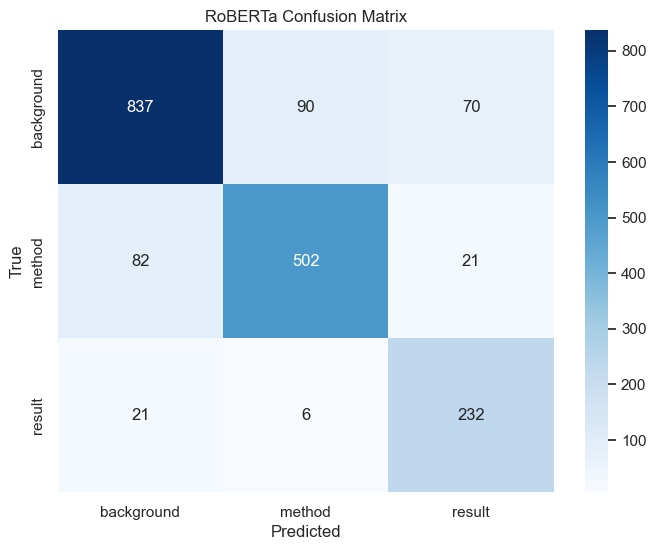

In [6]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RoBERTa Confusion Matrix')
plt.show()

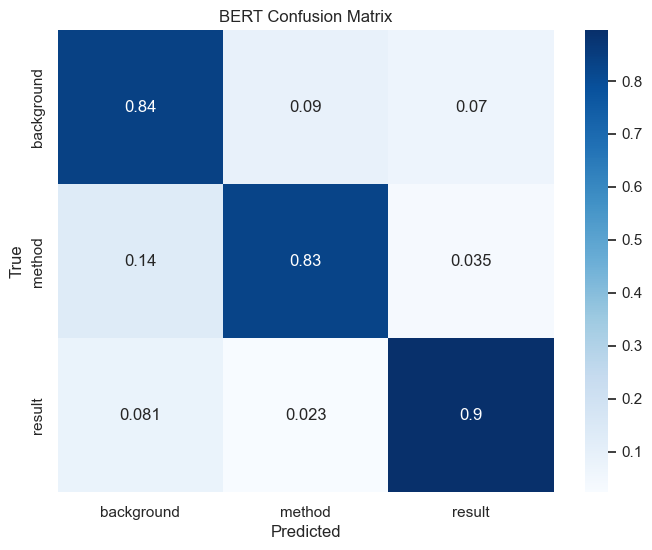

In [11]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()

Actually most misclassification comes from method being misclassified as background.

### Error Analysis

In [ ]:
test_df[(test_df["sectionName"] == "method") & (test_df["label"] == test_df["pred"])]

In [11]:
x = test_df.loc[(test_df["label"] == "method") & (test_df["label"] != test_df["pred"])]
x.sectionName.value_counts()

method          51
unknown         24
discussion      12
results         11
introduction     5
Name: sectionName, dtype: int64

In [59]:
x[x["pred"] == "method"].sectionName.value_counts()

discussion    5
results       1
Name: sectionName, dtype: int64

In [58]:
x[x["pred"] == "background"].sectionName.value_counts()

discussion    16
unknown        3
results        2
Name: sectionName, dtype: int64

In [56]:
y = test_df.loc[(test_df["label"] == "background") & (test_df["pred"] == "background")]
y.sectionName.value_counts()

discussion      442
results         194
unknown         123
introduction     66
method            8
background        4
Name: sectionName, dtype: int64

In [24]:
y = test_df.loc[(test_df["label"] == "method") & (test_df["pred"] == "method")]
y.sectionName.value_counts()

method                  363
unknown                  68
results                  55
discussion               15
material and methods      1
Name: sectionName, dtype: int64

In [26]:
y = test_df.loc[(test_df["label"] == "result") & (test_df["pred"] == "result")]
y.sectionName.value_counts()

discussion      203
results          16
unknown          11
introduction      2
Name: sectionName, dtype: int64

In [28]:
x = test_df.loc[(test_df["label"] != test_df["pred"])]
x.sectionName.value_counts()

discussion              118
results                  54
method                   53
unknown                  50
introduction             14
material and methods      1
Name: sectionName, dtype: int64

Substantial number of misclassified methods have section name "method", this should highly suggest that it is a method since background and result have very very few method section names.

### Examples of each label

In [ ]:
for row in train_df[train_df["label"] == "background"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "method"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "result"]["string"][:5]:
    print(row)
    print()

## Get Attributions

### Calculate all attributions

In [10]:
def predict(inputs, mask):
    output = model(inputs, attention_mask=mask)  # model(input_ids, attention_mask=attention_mask)
    return F.softmax(output.logits, dim=-1)


def predict2(inputs, mask):
    output = model(inputs, attention_mask=mask)
    return torch.sigmoid(output.logits).max(1).indices


def interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target="pred", device="cpu", debug=False):
    model.zero_grad()
    text = tokenizer.tokenize(sentence)

    # input_indices = torch.tensor([tokenizer.encode(sentence, padding="max_length", max_length=max_len)]).to(device)
    #input_indices = input_indices.unsqueeze(0)
    text_enc = tokenizer.encode_plus(sentence, padding="max_length", max_length=max_len)
    input_indices = torch.tensor([text_enc["input_ids"]]).to(device)
    mask = torch.tensor([text_enc["attention_mask"]]).to(device)

    # predict
    pred_probs = predict(input_indices, mask)
    pred_ind = predict2(input_indices, mask).item()
    pred = label_2_idx[pred_ind]

    # generate reference indices for each sample
    # reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    reference_indices = input_indices.clone()
    reference_indices[(input_indices != 0) & (input_indices != 2)] = 1
    reference_indices.to(device)
    ref_mask = torch.zeros(reference_indices.size()).to(device)
    # compute attributions and approximation delta using layer integrated gradients
    label_idx = label_2_idx.index(label)
    if target == "pred":
        target = pred_ind
    else:
        target = label_idx
    attributions_ig, delta = lig.attribute((input_indices, mask), (reference_indices, ref_mask), target=target, n_steps=50, return_convergence_delta=True)
    if debug:
        print(text)
        print(f"Ref: {reference_indices}")
        print(f"Input indices: {input_indices}")
        print(attributions_ig.sum(dim=2).squeeze(0))
        print(f"last non-zero index: {attributions_ig.sum(dim=2).squeeze(0).nonzero().max()}, {(input_indices[0] == 2).nonzero(as_tuple=True)[0].item()}")
        print(pred_ind, pred)
        print(pred_probs)
        print('pred: ', pred_ind, '(', '%.2f'%pred_probs.max(1).values, ')', ', delta: ', abs(delta))

    text = [tokenizer.decode(idx) for idx in input_indices[0]]

    add_attributions_to_visualizer(attributions_ig, text, pred_probs, pred, label, delta, vis_data_records_ig)


def add_attributions_to_visualizer(attributions, text, pred_probs, pred, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # Remove padding
    try:
        first_pad_idx = text.index(tokenizer.pad_token)
        text = text[:first_pad_idx]
        attributions = attributions[:first_pad_idx]
    except ValueError:
        pass
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_probs.max(1).values.item(),
                            pred,
                            label,
                            0,
                            attributions.sum(),
                            text,
                            delta))


def interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=0, target="pred", device="cpu", debug=False):
    vis_data_records_ig = []

    lig = LayerIntegratedGradients(predict, model.roberta.embeddings)
    
    token_reference = TokenReferenceBase(reference_token_idx=pad_idx)

    for idx, row in df.iterrows():
        torch.cuda.empty_cache()
        sentence = row["string"]
        label = row["label"]
        interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target=target, device=device, debug=debug)
    return vis_data_records_ig

In [10]:
# all_attributions = list()
# torch.cuda.empty_cache()
# vis_data_records_ig = interpret_batch(test_df, model, predict, max_len, label_2_idx, pad_idx=1, target="pred", device=device, debug=False)
# all_attributions = [{"input_ids": record.raw_input_ids, 
#                      "attributions": record.word_attributions, 
#                      "label": record.true_class, 
#                      "pred": record.pred_class, 
#                     } for record in vis_data_records_ig]

background
method
result


In [12]:
# Save attributions to prevent the need for running calculations again
# with open("attributions.pkl", "wb") as f:
#     pickle.dump(all_attributions, f)
with open("../attributions/attributions.pkl", "rb") as f:
    all_attributions = pickle.load(f)

### Analyze Attributions

In [7]:
def get_ngram_attributions(records, pred, n=1):
    ngram_attrs = defaultdict(lambda: [[]])
    for record in records:
        if record["pred"] == pred:
            tokens = record["input_ids"]
            attributions = record["attributions"]
            for i in range(len(tokens) + n - 1):
                ngram = tuple(tokens[i:i+n])
                ngram_attr = attributions[i:i+n].sum() / n
                ngram_attrs[ngram][0].append(ngram_attr)
    return ngram_attrs


def get_ngram_attribution_df(ngram_attributions):
    ngram_attributions_df = pd.DataFrame.from_dict(ngram_attributions, orient="index").reset_index().rename(columns={"index": "ngram", 0: "attribution"})

    ngram_attributions_df.attribution = ngram_attributions_df.attribution.apply(lambda x: np.array(x))
    ngram_attributions_df["mean"] = ngram_attributions_df.attribution.apply(lambda x: x.mean())
    ngram_attributions_df["median"] = ngram_attributions_df.attribution.apply(lambda x: np.median(x))
    ngram_attributions_df["std"] = ngram_attributions_df.attribution.apply(lambda x: x.std())
    ngram_attributions_df["count"] = ngram_attributions_df.attribution.apply(lambda x: len(x))
    
    ngram_attributions_df.sort_values("mean", ascending=False, inplace=True)
    
    return ngram_attributions_df

In [14]:
label = "background"  # background, method, result
target = "pred"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to pred:


Incorrectly classified texts with reference to pred:


In [15]:
label = "background"  # background, method, result
target = "label"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to label:


Incorrectly classified texts with reference to label:


In [16]:
label = "background"  # background, method, result
pred = "method"
target = "pred"

print(f"Classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == pred)].iloc[:10]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Classified texts with reference to pred:


### Get distribution of attribution scores

Background mean: 0.01, median: 0.01, max: 0.92, min: -0.97, std: 0.14
Method mean: 0.03, median: 0.01, max: 0.99, min: -0.97, std: 0.13
Result mean: 0.04, median: 0.01, max: 0.98, min: -0.76, std: 0.12


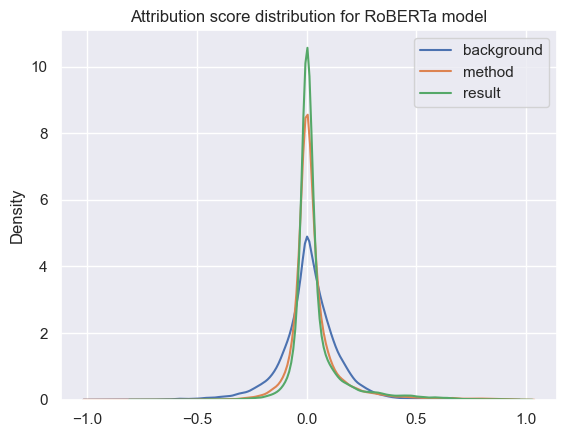

In [14]:
background_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "background"]
method_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "method"]
result_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "result"]
plt.title("Attribution score distribution for RoBERTa model")
sns.kdeplot(background_attributions, label="background")
sns.kdeplot(method_attributions, label="method")
sns.kdeplot(result_attributions, label="result")
plt.legend()
print(f"Background mean: {np.mean(background_attributions):.2f}, median: {np.median(background_attributions):.2f}, max: {np.max(background_attributions):.2f}, min: {np.min(background_attributions):.2f}, std: {np.std(background_attributions):.2f}")
print(f"Method mean: {np.mean(method_attributions):.2f}, median: {np.median(method_attributions):.2f}, max: {np.max(method_attributions):.2f}, min: {np.min(method_attributions):.2f}, std: {np.std(method_attributions):.2f}")
print(f"Result mean: {np.mean(result_attributions):.2f}, median: {np.median(result_attributions):.2f}, max: {np.max(result_attributions):.2f}, min: {np.min(result_attributions):.2f}, std: {np.std(result_attributions):.2f}")

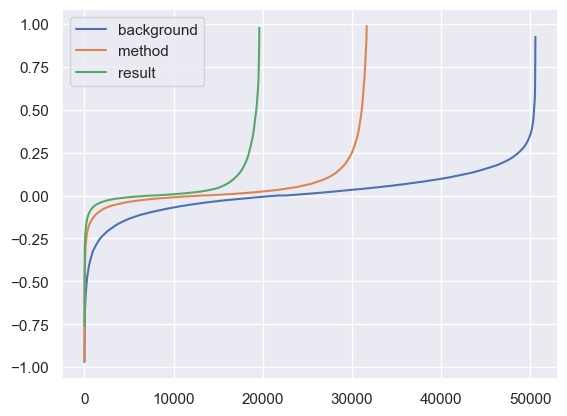

In [10]:
background_attributions.sort()
method_attributions.sort()
result_attributions.sort()
sns.lineplot(background_attributions, label="background")
sns.lineplot(method_attributions, label="method")
sns.lineplot(result_attributions, label="result")
plt.legend()

Attribution distribution for method and result labels are narrower, suggesting that there is a smaller set of words that determine the labels for these 2. More certainty of the 2 labels when certain words appear.

### Get top n tokens for each label

In [22]:
n = 30

top_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    top_n_tokens[pred] = set(toks)

bot_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=True)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    bot_n_tokens[pred] = set(toks)

#### Find the proportion of top n tokens in sentences

In [25]:
def get_proportions_top_n(n_tokens, correct_pred=True, reference="pred"):
    correct = "correctly" if correct_pred else "wrongly"
    ref = f" from {reference} class" if not correct_pred else ""
    print(f"Proportion of {correct} labelled records with n tokens{ref} in them.")
    for pred in ("background", "method", "result"):
        tot_correct_pred = 0
        tot_correct_w_top_n_pred = 0
        for record in all_attributions:
            if record["pred"] == pred and (record["pred"] == record["label"] if correct_pred else record["pred"] != record["label"]):
                tot_correct_pred += 1
                for tok in record["input_ids"]:
                    if tok in n_tokens[pred if reference == "pred" else record["label"]]:
                        tot_correct_w_top_n_pred += 1
                        break
        print(pred, tot_correct_w_top_n_pred, tot_correct_pred, tot_correct_w_top_n_pred / tot_correct_pred)

In [26]:
get_proportions_top_n(top_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 159 848 0.1875
method 167 497 0.33601609657947684
result 108 238 0.453781512605042

Proportion of wrongly labelled records with n tokens from pred class in them.
background 14 106 0.1320754716981132
method 30 81 0.37037037037037035
result 45 91 0.4945054945054945

Proportion of wrongly labelled records with n tokens from label class in them.
background 39 106 0.36792452830188677
method 8 81 0.09876543209876543
result 12 91 0.13186813186813187


In [27]:
get_proportions_top_n(bot_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 182 848 0.21462264150943397
method 144 497 0.289738430583501
result 112 238 0.47058823529411764

Proportion of wrongly labelled records with n tokens from pred class in them.
background 16 106 0.1509433962264151
method 19 81 0.2345679012345679
result 45 91 0.4945054945054945

Proportion of wrongly labelled records with n tokens from label class in them.
background 39 106 0.36792452830188677
method 16 81 0.19753086419753085
result 17 91 0.18681318681318682


### Get high attribution N-grams

In [ ]:
pred = "background"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 1) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "method"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 1) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "result"
n = 1

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 1) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

#### Why are the ngrams for background so shit?
Check if there are alot more [0] kind of tokens in background texts.

In [106]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("\[[^\]]*\]", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.5217903415783275 0.0 16 0
method 0.6471774193548387 0.0 7 0
result 0.6 0.0 10 0


In [107]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("et[^(et)]*al", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.8845700824499411 0.0 15 0
method 0.5443548387096774 0.0 7 0
result 1.0085106382978724 0.0 15 0


### Get high attribution phrases by threshold

In [39]:
high_attr_ngrams = {"background": [], "method": [], "result": []}
thr = 0.2
for record in all_attributions:
    pred = record["pred"]
    tokens = record["input_ids"]
    attributions = record["attributions"]
    subtok = list()
    subattr = list()
    for i in range(len(tokens)):
        if sum(subattr) + attributions[i] > thr * (len(subtok) + 1):  # averaged threshold
        # if attributions[i] > thr:  # hard threshold
            subtok.append(tokens[i])
            subattr.append(attributions[i])
        elif subtok:
            high_attr_ngrams[pred].append([subtok, subattr])
            subtok = list()
            subattr = list()

In [41]:
ngram_attrs = high_attr_ngrams["method"]
Counter(" ".join(pair[0]) for pair in ngram_attrs)

Counter({' the': 56,
         ' by': 20,
         ' (': 18,
         ' was': 18,
         ' were': 16,
         ' of': 16,
         ' with': 15,
         'The': 12,
         ' and': 11,
         ' from': 9,
         ' model': 9,
         ' used': 8,
         ')': 8,
         '.': 8,
         ' using': 8,
         '),': 7,
         ' as': 7,
         ' method': 7,
         ' in': 6,
         '-': 5,
         ' a': 4,
         ' data': 4,
         ' to': 4,
         ' technique': 4,
         'For': 4,
         'We': 4,
         'To': 4,
         ' model ,': 3,
         ' is': 3,
         ' on': 3,
         ' are': 3,
         ' method  (': 3,
         ' process': 3,
         ' we': 3,
         ' previous': 3,
         ' with  the': 3,
         ' using  the': 3,
         ' implementation': 3,
         ' previously': 3,
         ' have': 2,
         ' datasets': 2,
         ' each': 2,
         ' by  the': 2,
         ' with  a': 2,
         'A': 2,
         ' during': 2,
         ' based'

### Error Analysis comparison with SciBERT

In [47]:
df = test_df[(test_df.label == "method") & (test_df.pred == "result")]

In [ ]:
for i, row in df.iterrows():
    print(row["string"])
    print()